# Preamble

In [1]:
!date

Wed Nov 20 08:27:14 PST 2024


In [2]:
%load_ext autoreload
%load_ext line_profiler

In [3]:
import logging

logging.basicConfig(level=logging.INFO, force=True)

In [4]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])

In [5]:
import os
from contextlib import contextmanager
from itertools import chain, product
from multiprocessing import Pool

import fastcluster
import graph_tool as gt
import graph_tool.draw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import strainzip as sz
import strainzip.app.unzip
import xarray as xr
from graph_tool.util import find_edge
from scipy.cluster.hierarchy import fcluster, linkage
from strainzip.pandas_util import idxwhere
from tqdm import tqdm

import lib.plot

# Params

## Plotting

In [6]:
mpl.rcParams["figure.dpi"] = 100
# sns.set_context('talk')

In [7]:
# Plotting parameters

length_bins = np.logspace(0, 6.5, num=51)
depth_bins = np.logspace(-1, 4, num=51)

draw_graphs = True

## Which assembly / output dir

In [8]:
k = 111
group = "btheta_mixture1"
graph_type = f"k{k}-withmegahit3-droptips"
smoothing = "smoothed-6"
deconv = "norm-nobal-nocull-10-10"
clust_params = "e50-n20000-d20"
marker_model = 'TIGR02013'

# StrainZip

## Depth

In [9]:
%%time
final_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.sz"
)
final_results = sz.results.extract_vertex_data(final_graph)

vertex_depth = sz.results.depth_table(final_graph, final_graph.get_vertices()).T
vertex_length = pd.Series(final_graph.vp["length"], index=final_graph.get_vertices())

CPU times: user 125 ms, sys: 17.5 ms, total: 142 ms
Wall time: 143 ms


## Gene metadata

In [10]:
strainzip_gene = (
    pd.read_table(
        f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.prodigal.bed",
        names=["contig", "left", "right", "orf", "score", "strand"],
    )
    .assign(vertex=lambda x: x.contig.str.split("_"))
    .explode('vertex')
    .astype({'vertex': int})
    .reset_index(drop=True)
)
strainzip_gene

,contig,left,right,orf,score,strand,vertex
0,1002_966,0,108,1002_966[0-108]+,0,+,1002
1,1002_966,0,108,1002_966[0-108]+,0,+,966
2,1002_966,243,1635,1002_966[243-1635]-,0,-,1002
3,1002_966,243,1635,1002_966[243-1635]-,0,-,966
4,1002_966,1877,2057,1002_966[1877-2057]+,0,+,1002
...,...,...,...,...,...,...,...
56023,996_1030,245,443,996_1030[245-443]-,0,-,1030
56024,99_65,0,162,99_65[0-162]+,0,+,99
56025,99_65,0,162,99_65[0-162]+,0,+,65
56026,9_0,95,221,9_0[95-221]-,0,-,9


In [11]:
strainzip_marker_gene_list = (
    pd.read_table(
        f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.cds.tran.hmmer-{marker_model}-ga.tsv",
        names=["orf", "gene_name", "bitscore"],
    )
    .orf.tolist()
)



print(strainzip_marker_gene_list)

total_strainzip_marker_depth = vertex_depth.loc[strainzip_gene[lambda x: x.orf.isin(strainzip_marker_gene_list)].vertex].sum()
normalized_vertex_depth = vertex_depth.divide(total_strainzip_marker_depth)
total_strainzip_marker_depth

['2104_2113[1320-5133]-', '2226_2162[2-2867]-', '2312_2613[2-2867]-', '2436_2444[2-2867]-']


0    42.382561
1    42.039448
2    42.283470
3    42.527854
4    42.811361
dtype: float64

## Gene-wise

In [12]:
strainzip_normalized_gene_depth = normalized_vertex_depth.loc[strainzip_gene.vertex].reset_index(drop=True)
strainzip_normalized_gene_depth

,0,1,2,3,4
0,0.519080,0.001424,0.248116,0.127509,0.373251
1,0.519080,0.001424,0.248116,0.127509,0.373251
2,0.519080,0.001424,0.248116,0.127509,0.373251
3,0.519080,0.001424,0.248116,0.127509,0.373251
4,0.519080,0.001424,0.248116,0.127509,0.373251
...,...,...,...,...,...
56023,0.483413,0.003272,0.151914,0.134055,0.384736
56024,0.000634,0.511098,0.241657,0.351077,0.131156
56025,0.000634,0.511098,0.241657,0.351077,0.131156
56026,0.000066,0.497385,0.341324,0.404858,0.115233


Text(0.5, 0, 'Normalized Gene Depth\n(mean over reads from all samples)')

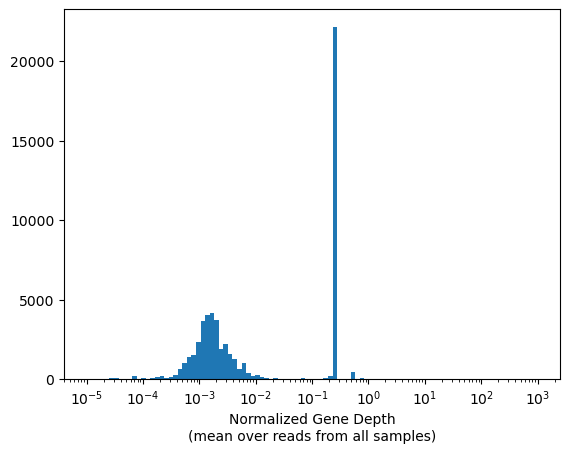

In [13]:
bins = [0] + list(np.logspace(-5, 3, num=100))
plt.hist(strainzip_normalized_gene_depth.mean(1), bins=bins)
plt.xscale("log")
plt.xlabel("Normalized Gene Depth\n(mean over reads from all samples)")

Text(0.5, 0, 'Normalized Gene Depth\n(maximum over reads from all samples)')

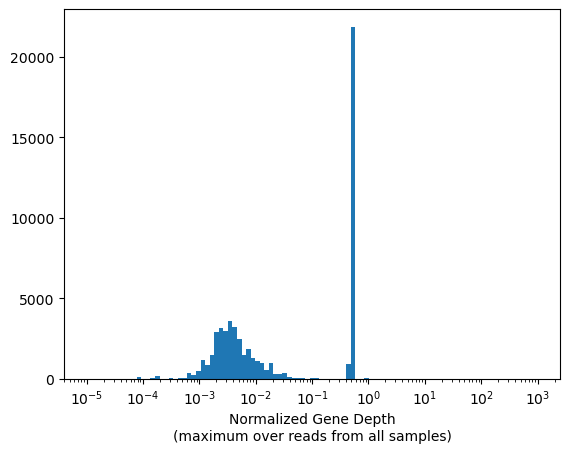

In [14]:
bins = [0] + list(np.logspace(-5, 3, num=100))
plt.hist(strainzip_normalized_gene_depth.max(1), bins=bins)
plt.xscale("log")
plt.xlabel("Normalized Gene Depth\n(maximum over reads from all samples)")

Text(0.5, 0, 'Normalized Gene Depth\n(Mixed sample)')

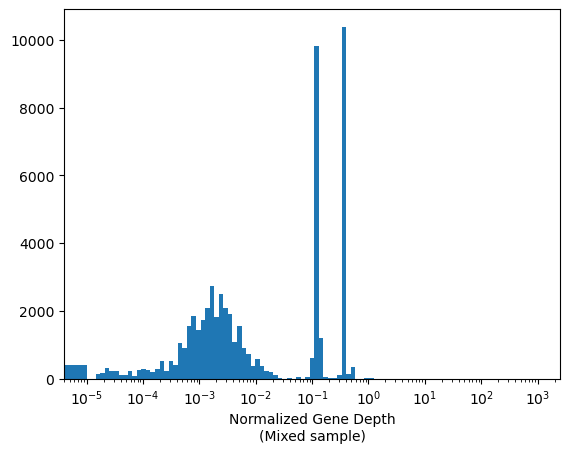

In [15]:
bins = [0] + list(np.logspace(-5, 3, num=100))
plt.hist(strainzip_normalized_gene_depth.iloc[:, 3], bins=bins)
plt.xscale("log")
plt.xlabel("Normalized Gene Depth\n(Mixed sample)")

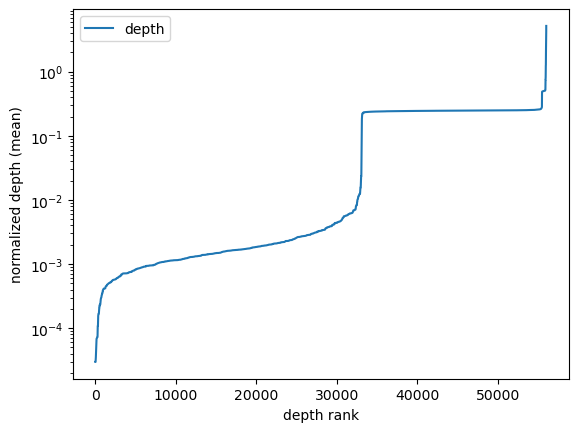

In [16]:
d = (
    strainzip_normalized_gene_depth.mean(1)
    .to_frame(name="mean_normalized_depth")
    .sort_values('mean_normalized_depth')
    .assign(rank=lambda x: x.mean_normalized_depth.rank())
)

plt.plot(
    "rank", "mean_normalized_depth", data=d, label="depth"
)
plt.xlabel("depth rank")
plt.ylabel("normalized depth (mean)")
# plt.plot("mean_normalized_depth", "length_cumsum", data=d)
plt.yscale("log")
plt.legend()
# plt.xscale("logit")

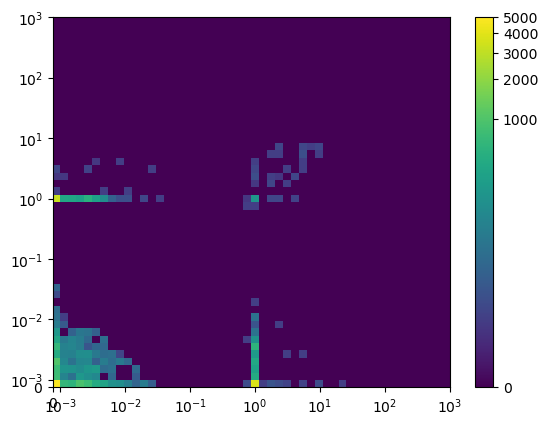

In [17]:
d = strainzip_normalized_gene_depth
# NOTE (2024-11-19): We correct the depths by 2 and then downweight each gene by 1/2 to account for reverse complements.

bins = [0] + list(np.logspace(-3, 3, num=50))

plt.hist2d(d.iloc[:, 0] * 2, d.iloc[:, 1] * 2, bins=bins, norm=mpl.colors.PowerNorm(1/5, vmin=0, vmax=5_000), weights=d.assign(weight=1 / 2).weight)
plt.xscale('symlog', linthresh=1e-3, linscale=0.1)
plt.yscale('symlog', linthresh=1e-3, linscale=0.1)
plt.colorbar()

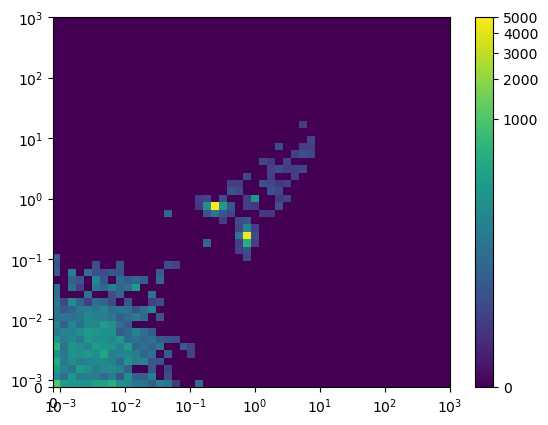

In [18]:
d = strainzip_normalized_gene_depth
# NOTE (2024-11-19): We correct the depths by 2 and then downweight each gene by 1/2 to account for reverse complements.

bins = [0] + list(np.logspace(-3, 3, num=50))

plt.hist2d(d.iloc[:, 3] * 2, d.iloc[:, 4] * 2, bins=bins, norm=mpl.colors.PowerNorm(1/5, vmin=0, vmax=5_000), weights=d.assign(weight=1 / 2).weight)
plt.xscale('symlog', linthresh=1e-3, linscale=0.1)
plt.yscale('symlog', linthresh=1e-3, linscale=0.1)
plt.colorbar()

### Depth Filtered

In [19]:
import sklearn.decomposition

d = strainzip_normalized_gene_depth#[strainzip_normalized_gene_depth.max(1) > 0.1]
w, h, _it = sklearn.decomposition.non_negative_factorization(d, n_components=5, solver='mu', max_iter=1000)

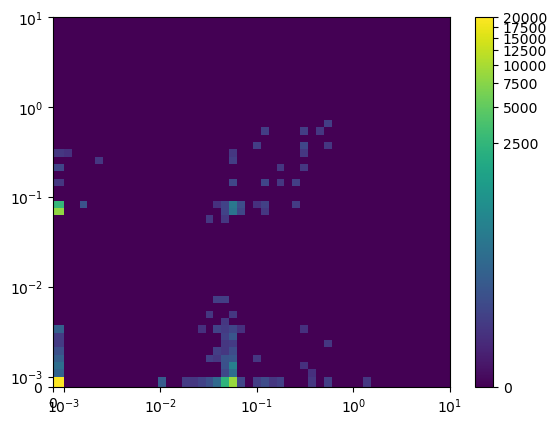

In [20]:
bins = [0] + list(np.logspace(-3, 1, num=50))

plt.hist2d(w[:,0], w[:,1], bins=bins, norm=mpl.colors.PowerNorm(1/5, vmin=0, vmax=20_000))
plt.yscale('symlog', linthresh=1e-3, linscale=0.1)
plt.xscale('symlog', linthresh=1e-3, linscale=0.1)
plt.colorbar()

## Vertex-wise

Text(0.5, 0, 'Normalized Vertex Depth\n(mean over reads from two different strains)')

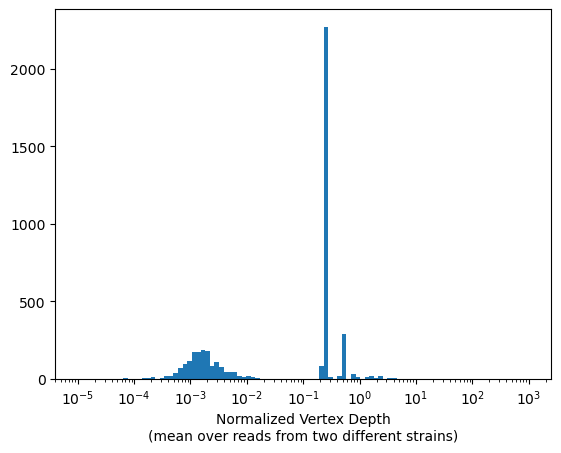

In [21]:
bins = [0] + list(np.logspace(-5, 3, num=100))
plt.hist(normalized_vertex_depth.mean(1), bins=bins)
plt.xscale("log")
plt.xlabel("Normalized Vertex Depth\n(mean over reads from two different strains)")

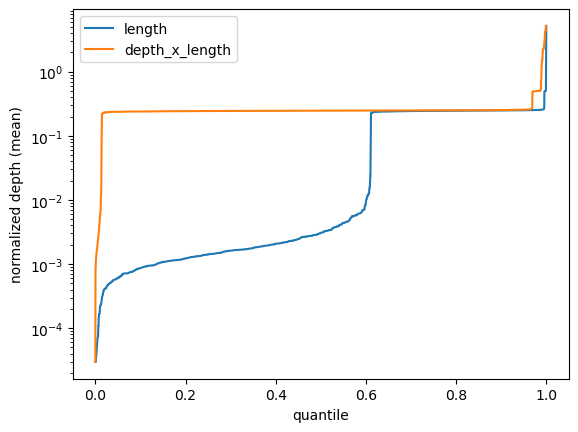

In [22]:
d = (
    normalized_vertex_depth.mean(1)
    .to_frame(name="total_normalized_depth")
    .join(final_results.length)
    .sort_values("total_normalized_depth", ascending=True)
    .assign(
        depth_x_length=lambda x: x.total_normalized_depth * x.length,
        depth_x_length_cumsum=lambda x: x.depth_x_length.cumsum(),
        length_cumsum=lambda x: x.length.cumsum(),
        depth_x_length_quantile=lambda x: x.depth_x_length_cumsum
        / x.depth_x_length_cumsum.max(),
        length_quantile=lambda x: x.length_cumsum / x.length_cumsum.max(),
    )
)

plt.plot("length_quantile", "total_normalized_depth", data=d, label="length")
plt.plot(
    "depth_x_length_quantile", "total_normalized_depth", data=d, label="depth_x_length"
)
plt.xlabel("quantile")
plt.ylabel("normalized depth (mean)")
# plt.plot("mean_normalized_depth", "length_cumsum", data=d)
plt.yscale("log")
plt.legend()
# plt.xscale("logit")

# MEGAHIT / Read-Mapping

## Depth

In [23]:
sample_list = ['btheta_strainA_simcom_len150_seed0_cov10000',
               'btheta_strainB_simcom_len150_seed0_cov10000',
               'btheta_mixture_50_50_simcom_len150_seed1_cov10000',
               'btheta_mixture_25_75_simcom_len150_seed2_cov10000',
               'btheta_mixture_75_25_simcom_len150_seed3_cov10000']

megahit_gene_depth = {}
for sample in sample_list:
    inpath = f"data/group/{group}/reads/{sample}/r.proc.megahit-full-k111.prodigal.gene_depth.tsv"
    megahit_gene_depth[sample] = pd.read_table(inpath, names=['orf', 'depth'], index_col='orf').depth

megahit_gene_depth = pd.DataFrame(megahit_gene_depth).fillna(0)
megahit_gene_depth

,btheta_strainA_simcom_len150_seed0_cov10000,btheta_strainB_simcom_len150_seed0_cov10000,btheta_mixture_50_50_simcom_len150_seed1_cov10000,btheta_mixture_25_75_simcom_len150_seed2_cov10000,btheta_mixture_75_25_simcom_len150_seed3_cov10000
orf,,,,,
k111_1001[0-270]-,0.000000,37.229630,7.570370,30.885185,10.111111
k111_1002[0-1389]+,98.268539,94.923686,52.692585,100.946724,97.930886
k111_1002[1543-2917]+,91.526201,95.229985,70.997817,105.510917,95.360262
k111_1002[3421-3613]-,80.614583,72.645833,53.854167,59.567708,74.500000
k111_1003[1878-2616]-,0.000000,95.775068,33.409214,72.096206,30.663957
...,...,...,...,...,...
k111_997[8291-9680]-,92.862491,98.728582,76.708423,99.583873,100.303816
k111_997[9970-10366]-,101.532828,102.944444,73.689394,93.661616,94.315657
k111_998[2-461]+,18.379085,21.812636,6.723312,22.688453,15.540305


## Gene metadata

In [24]:
megahit_gene = (
    pd.read_table(
        f"data/group/{group}/r.proc.megahit-full-k111.prodigal.bed",
        names=["contig", "left", "right", "orf", "score", "strand"],
    )
)
megahit_gene

,contig,left,right,orf,score,strand
0,k111_1,1,946,k111_1[1-946]+,0,+
1,k111_1,1060,3490,k111_1[1060-3490]-,0,-
2,k111_1,3647,4160,k111_1[3647-4160]-,0,-
3,k111_10,1,1573,k111_10[1-1573]+,0,+
4,k111_10,1611,2472,k111_10[1611-2472]+,0,+
...,...,...,...,...,...,...
7315,k111_997,45019,47659,k111_997[45019-47659]-,0,-
7316,k111_997,47723,48362,k111_997[47723-48362]-,0,-
7317,k111_997,48456,49521,k111_997[48456-49521]+,0,+
7318,k111_997,49625,50330,k111_997[49625-50330]+,0,+


In [25]:
megahit_marker_gene_list = (
    pd.read_table(
        f"data/group/{group}/r.proc.megahit-full-k111.cds.tran.hmmer-{marker_model}-ga.tsv",
        names=["orf", "gene_name", "bitscore"],
    )
    .orf.tolist()
)

print(megahit_marker_gene_list)

megahit_total_marker_depth = megahit_gene_depth.loc[megahit_marker_gene_list].sum()

['k111_142[24260-28073]+']


## Gene-wise

In [26]:
megahit_normalized_gene_depth = megahit_gene_depth.divide(megahit_total_marker_depth)
megahit_normalized_gene_depth

,btheta_strainA_simcom_len150_seed0_cov10000,btheta_strainB_simcom_len150_seed0_cov10000,btheta_mixture_50_50_simcom_len150_seed1_cov10000,btheta_mixture_25_75_simcom_len150_seed2_cov10000,btheta_mixture_75_25_simcom_len150_seed3_cov10000
orf,,,,,
k111_1001[0-270]-,0.000000,0.368765,0.076454,0.315666,0.101661
k111_1002[0-1389]+,0.991359,0.940234,0.532150,1.031739,0.984639
k111_1002[1543-2917]+,0.923340,0.943268,0.717017,1.078388,0.958793
k111_1002[3421-3613]-,0.813261,0.719568,0.543881,0.608819,0.749055
k111_1003[1878-2616]-,0.000000,0.948667,0.337404,0.736869,0.308308
...,...,...,...,...,...
k111_997[8291-9680]-,0.936821,0.977922,0.774689,1.017810,1.008497
k111_997[9970-10366]-,1.024290,1.019681,0.744199,0.957281,0.948290
k111_998[2-461]+,0.185413,0.216058,0.067900,0.231890,0.156249


Text(0.5, 0, 'Normalized Gene Depth\n(mean over reads from two different strains)')

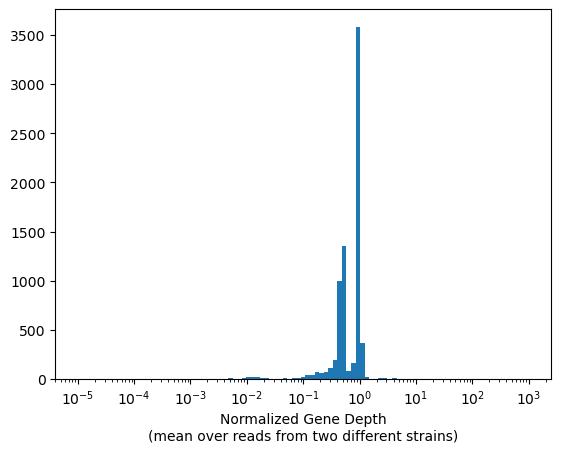

In [27]:
bins = [0] + list(np.logspace(-5, 3, num=100))
plt.hist(megahit_normalized_gene_depth.mean(1), bins=bins)
plt.xscale("log")
plt.xlabel("Normalized Gene Depth\n(mean over reads from two different strains)")

Text(0.5, 0, 'Normalized Gene Depth\n(Mixed sample)')

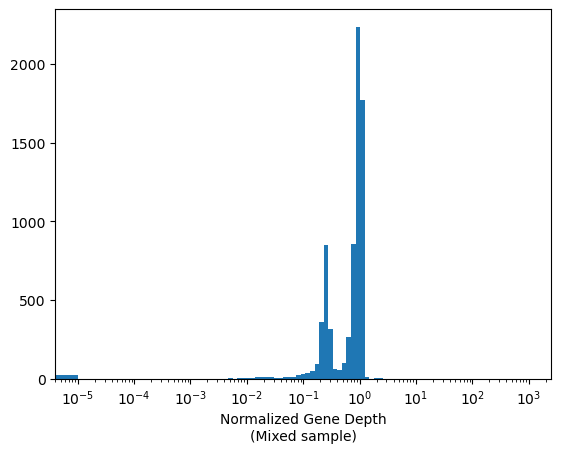

In [28]:
bins = [0] + list(np.logspace(-5, 3, num=100))
plt.hist(megahit_normalized_gene_depth.iloc[:, 3], bins=bins)
plt.xscale("log")
plt.xlabel("Normalized Gene Depth\n(Mixed sample)")

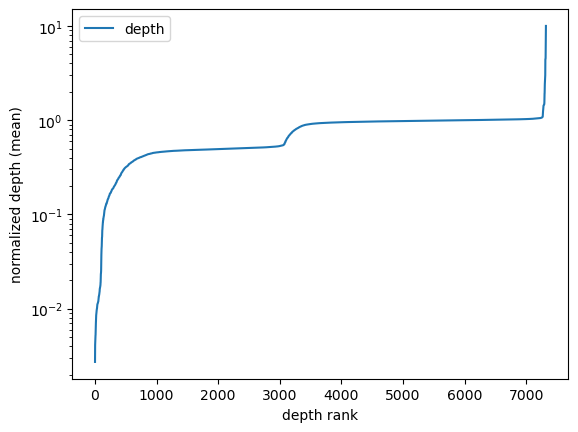

In [29]:
d = (
    megahit_normalized_gene_depth.mean(1)
    .to_frame(name="mean_normalized_depth")
    .sort_values('mean_normalized_depth')
    .assign(rank=lambda x: x.mean_normalized_depth.rank())
)

plt.plot(
    "rank", "mean_normalized_depth", data=d, label="depth"
)
plt.xlabel("depth rank")
plt.ylabel("normalized depth (mean)")
# plt.plot("mean_normalized_depth", "length_cumsum", data=d)
plt.yscale("log")
plt.legend()
# plt.xscale("logit")

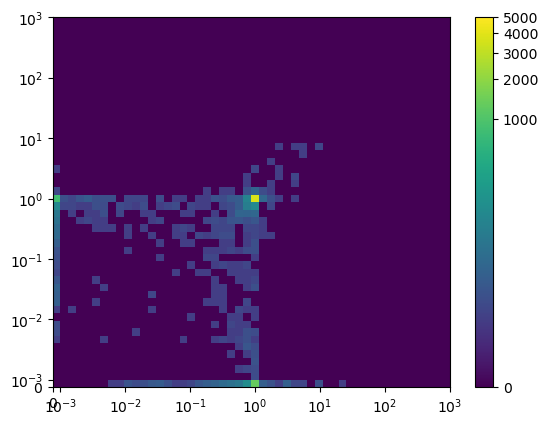

In [30]:
d = megahit_normalized_gene_depth

bins = [0] + list(np.logspace(-3, 3, num=50))
plt.hist2d(d.iloc[:, 0], d.iloc[:, 1], bins=bins, norm=mpl.colors.PowerNorm(1/5, vmin=0, vmax=5_000))
plt.xscale('symlog', linthresh=1e-3, linscale=0.1)
plt.yscale('symlog', linthresh=1e-3, linscale=0.1)
plt.colorbar()

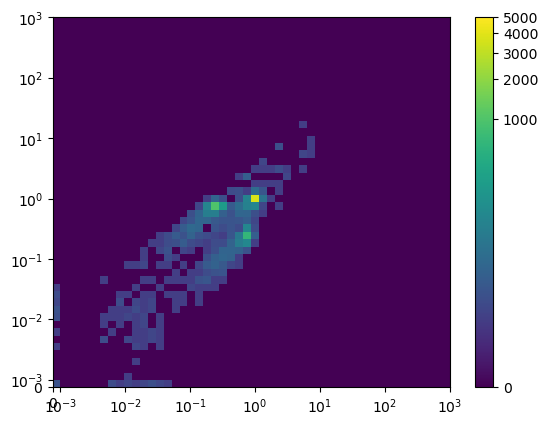

In [31]:
d = megahit_normalized_gene_depth

bins = [0] + list(np.logspace(-3, 3, num=50))
plt.hist2d(d.iloc[:, 3], d.iloc[:, 4], bins=bins, norm=mpl.colors.PowerNorm(1/5, vmin=0, vmax=5_000))
plt.xscale('symlog', linthresh=1e-3, linscale=0.1)
plt.yscale('symlog', linthresh=1e-3, linscale=0.1)
plt.colorbar()